# <font color = 'indianred'>**Emotion Detection - MultiLabel** </font>

**Plan**

1. Set Environment
2. Load Dataset
3. Load Pre-trained Tokenizer
4. Train Model
     1. Compute Metric Function <br>
     2. Training Arguments <br>
     3. Specify Model
     4. Instantiate Trainer <br>
     5. Setup WandB <br>
     6. Training and Validation






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing'
  sys.path.append('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')
else:
  basepath = '/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/'
  sys.path.append('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 39.9 MB/s 

<font color = 'indianred'> *Load Libraries* </font>

In [2]:

# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset, Dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import AutoConfig

import wandb
import evaluate
import os

In [3]:
from peft import (
    TaskType,
    LoraConfig,
    IA3Config,
    get_peft_model,
    prepare_model_for_kbit_training,
)

# <font color = 'indianred'> **2. Load_Dataset** </font>

In [4]:
emotion_data = load_dataset('harpreetmann/train_emotion_spring_2024')

Generating train split:   0%|          | 0/6179 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [5]:
emotion_data['train'][0:2]

{'text': ['Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry',
  'A not very young man compiled info on a smiling baby then a mattress created new evil.'],
 'label': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
  [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [6]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [7]:
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [8]:
checkpoint = "google/gemma-1.1-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [9]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [10]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [11]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [12]:
tokenized_dataset['train'][0]

{'label': tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.]),
 'input_ids': tensor([     2,  11227,   5596,   1230, 235269,    708,   2145,  59132,    575,
            476,  16629,   1606,   5248,   2145,  21357,    577,    573,   1809,
           6011, 235341,   1700, 232495]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1. compute_metrics function** </font>



In [13]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

## <font color = 'indianred'> **4.2. Training Arguments**</font>







In [14]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_gemma_tf_lora_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=10,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    # gradient_accumulation_steps=8,


    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # fp16=False,
    # bf16=False,
    # tf32= False
)


## <font color = 'indianred'> **4.3. Specify Model**</font>

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification" )

config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    

## <font color = 'indianred'> **4.4. LORA Setup**</font>

In [17]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['score',
 'up_proj',
 'v_proj',
 'q_proj',
 'down_proj',
 'k_proj',
 'o_proj',
 'gate_proj']

In [18]:
model = prepare_model_for_kbit_training(model)

In [19]:
gemma_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="lora_only",
    # modules_to_save = ['score'],
    target_modules="all-linear",
)
gemma_peft_model = get_peft_model(model, gemma_peft_config )
gemma_peft_model.print_trainable_parameters()

trainable params: 157,179,264 || all params: 2,663,637,760 || trainable%: 5.900924906545851


In [20]:
gemma_peft_model.config

GemmaConfig {
  "_name_or_path": "google/gemma-1.1-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 0,

##  <font color = 'indianred'> **4.4 Custom Trainer**</font>



In [21]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)

In [22]:
pos_weights

tensor([ 1.6795,  5.9349,  1.6519,  4.7002,  1.6947,  8.4192,  2.3988,  7.6541,
         2.3400, 18.6783, 19.1928])

In [23]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [24]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [25]:
trainer = CustomTrainer(
    model=gemma_peft_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer),

)

## <font color = 'indianred'> **4.5 Setup WandB**</font>

In [26]:
if 'google.colab' in str(get_ipython()):
    from google.colab import userdata
    wandb.login(key=userdata.get('wandb'))
else:
    !wandb login

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [27]:
%env WANDB_PROJECT = nlp_course_spring_2024-emotion-analysis-hf-trainer-hw8

env: WANDB_PROJECT=nlp_course_spring_2024-emotion-analysis-hf-trainer-hw7


## <font color = 'indianred'> **4.6. Start Training**</font>

In [28]:
tokenized_dataset['train']['label'].shape

torch.Size([6179, 11])

In [29]:
tokenized_dataset['valid']['label'].shape

torch.Size([1545, 11])

In [31]:
trainer.train()  # start training

wandb: Currently logged in as: harikrish0607 (harikrishnad). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.709500,0.603805,0.629529,0.518085,0.145631
40,0.529000,0.514961,0.671295,0.573461,0.172816
60,0.506100,0.501239,0.692267,0.573320,0.213592
80,0.512300,0.482451,0.688549,0.606457,0.208414
100,0.499000,0.480851,0.694071,0.605048,0.227184
120,0.345700,0.541930,0.676448,0.584974,0.200647
140,0.327800,0.555858,0.681553,0.570770,0.200000
160,0.349600,0.546085,0.674177,0.577101,0.188350
180,0.351700,0.539321,0.685853,0.583294,0.195469
200,0.291700,0.607828,0.677742,0.568322,0.242071


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
20,0.709500,0.603805,0.629529,0.518085,0.145631
40,0.529000,0.514961,0.671295,0.573461,0.172816
60,0.506100,0.501239,0.692267,0.573320,0.213592
80,0.512300,0.482451,0.688549,0.606457,0.208414
100,0.499000,0.480851,0.694071,0.605048,0.227184
120,0.345700,0.541930,0.676448,0.584974,0.200647
140,0.327800,0.555858,0.681553,0.570770,0.200000
160,0.349600,0.546085,0.674177,0.577101,0.188350
180,0.351700,0.539321,0.685853,0.583294,0.195469
200,0.291700,0.607828,0.677742,0.568322,0.242071


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

TrainOutput(global_step=970, training_loss=0.11937752995236786, metrics={'train_runtime': 2975.2294, 'train_samples_per_second': 20.768, 'train_steps_per_second': 0.326, 'total_flos': 3.716092892245248e+16, 'train_loss': 0.11937752995236786, 'epoch': 10.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [32]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [33]:
eval_results

{'eval_loss': 0.4824506342411041,
 'eval_f1_micro': 0.6885486834047765,
 'eval_f1_macro': 0.6064565250617231,
 'eval_accuracy': 0.20841423948220064,
 'eval_runtime': 19.9282,
 'eval_samples_per_second': 77.528,
 'eval_steps_per_second': 1.255,
 'epoch': 10.0}

In [35]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [36]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [41]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

In [42]:
predictions_valid

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

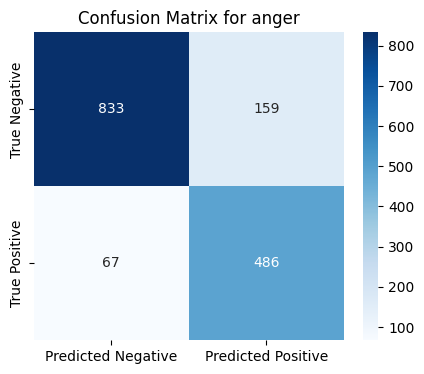

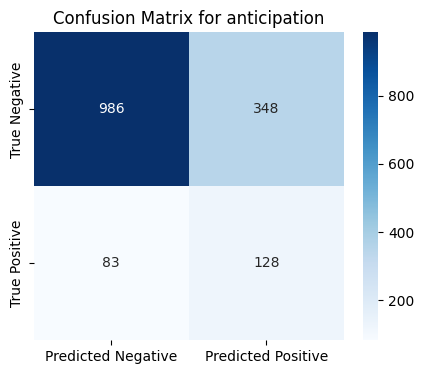

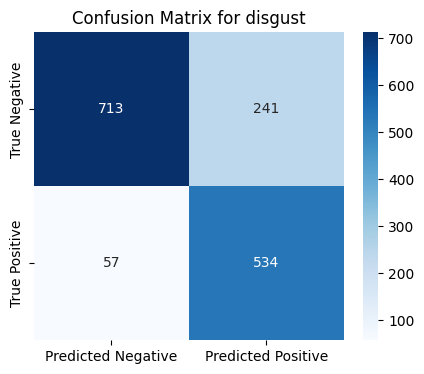

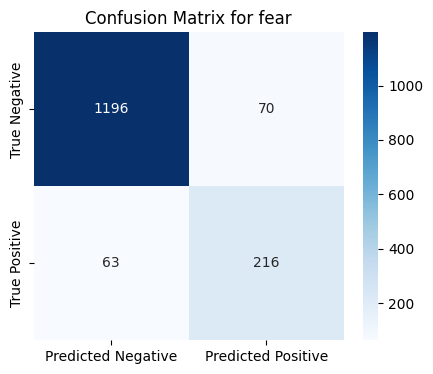

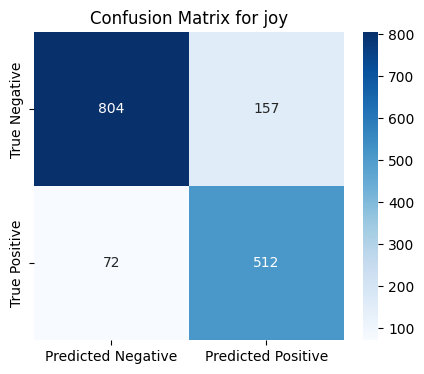

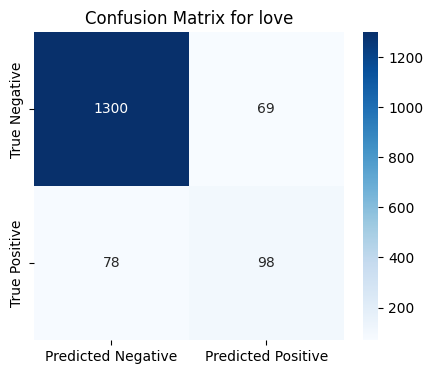

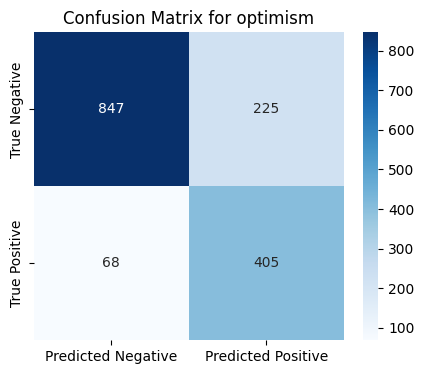

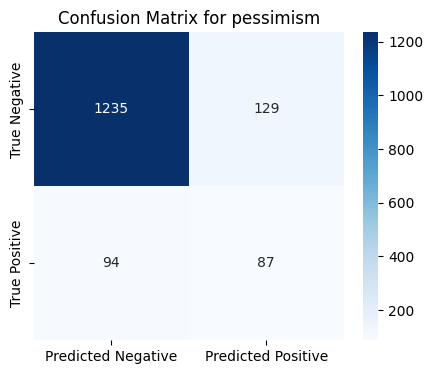

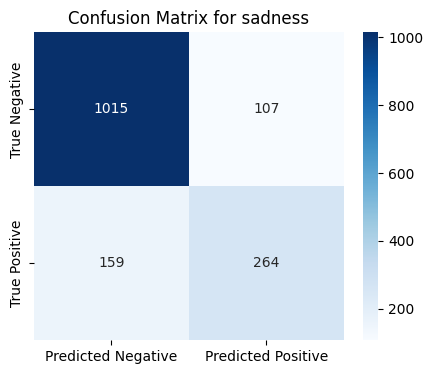

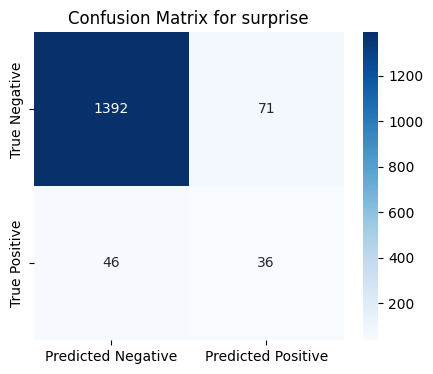

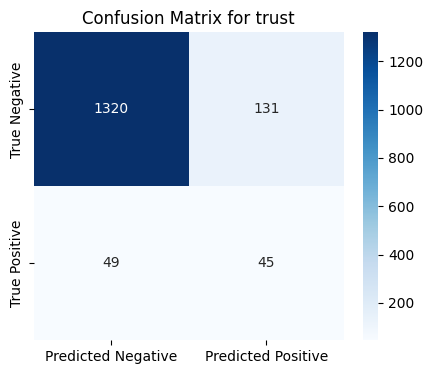

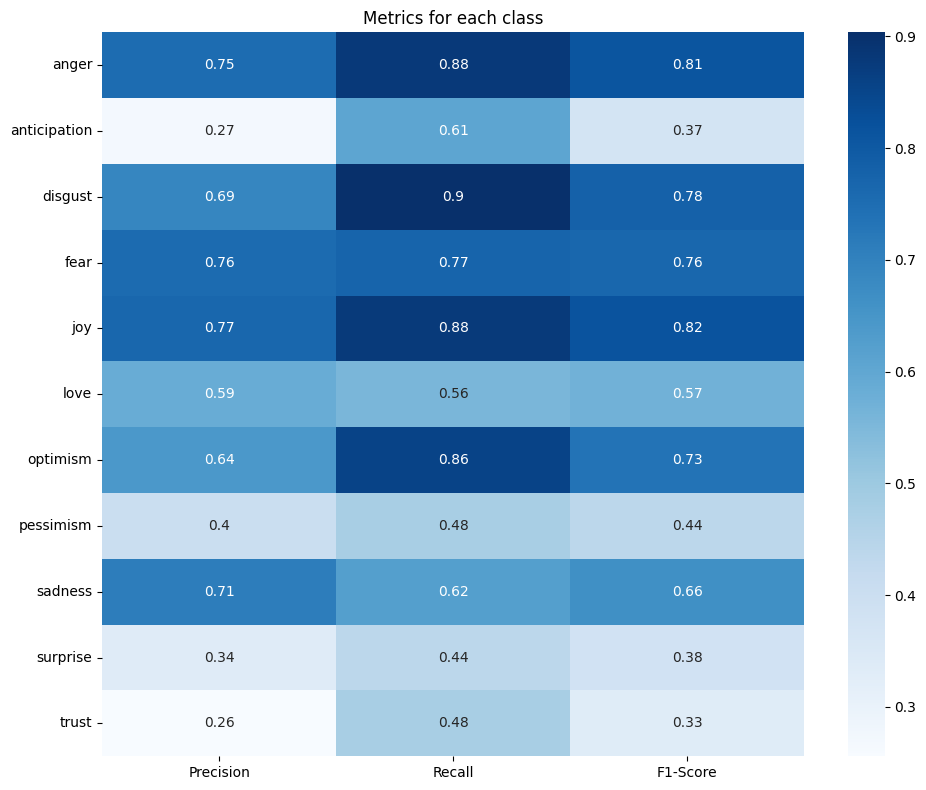

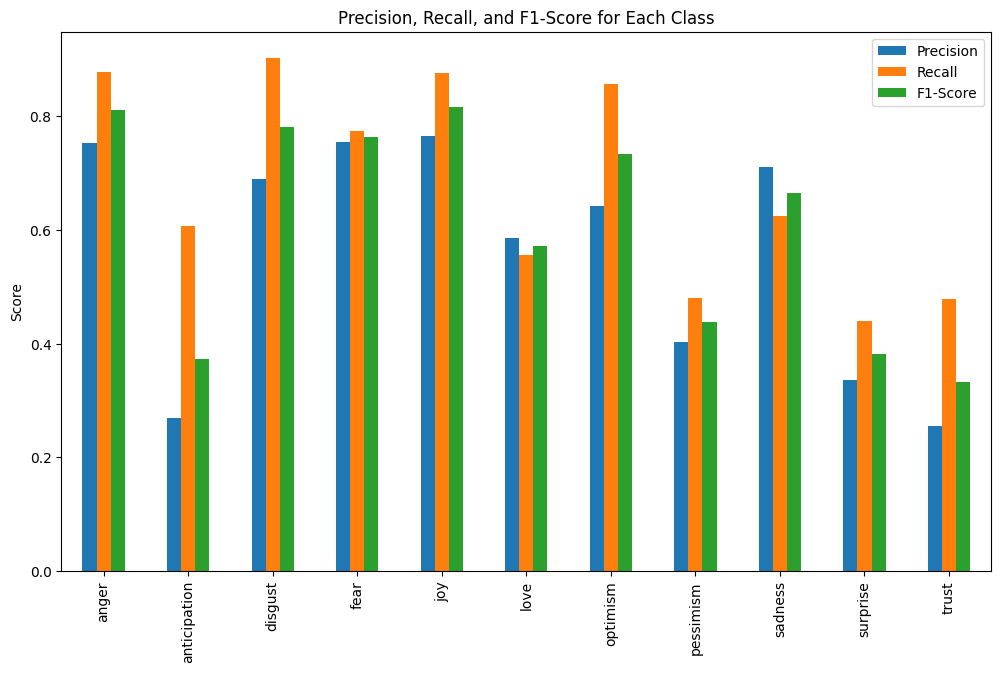

In [43]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [44]:
wandb.finish()

eval/accuracy,▁▃▅▅▆▄▃▄▆▃▄▅▆▆▆▆▇▆▆▆▇▆▇▇▇█▇▇▇▇█████████▅
eval/f1_macro,▁▅▅██▅▆▆▅▄▅▅▄▃▅▅▄▅▄▄▅▄▅▅▄▄▄▅▅▅▅▄▄▄▄▄▄▄▄█
eval/f1_micro,▁▆█▇█▇▆▇▆▅▆▆▆▆▅▆▇▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
eval/loss,▂▁▁▁▁▂▂▂▂▃▃▄▅▅▄▄▅▅▆▆▆▇▆▆▇▇▇▇▇▇█████████▁
eval/runtime,▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁█▁▁▁▁▁▂▂▂▂▁▂▁▂▃
eval/samples_per_second,▇████████▇██████▇███▇█▇██▁█████▇▇▇▇█▇█▇▆
eval/steps_per_second,▇████████▇████████████▇██▁█████████████▆
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [45]:
gemma_peft_model.push_to_hub("harikrishnad1997/gemma_lora_model_emotion_detection")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/631M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/harikrishnad1997/gemma_lora_model_emotion_detection/commit/2003492d3baf46e6694a56444ff3016b3e04e951', commit_message='Upload model', commit_description='', oid='2003492d3baf46e6694a56444ff3016b3e04e951', pr_url=None, pr_revision=None, pr_num=None)

# Test Set Predictions

In [46]:
test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/HW/test.csv')
test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [47]:
test.shape

(3259, 13)

In [48]:
from datasets import Dataset
testset = Dataset.from_dict({
    'text': test['Tweet']})

In [49]:
tokenized__test_dataset= testset.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized__test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [50]:
predictions = trainer.predict(tokenized_test_dataset)
predictions

PredictionOutput(predictions=array([[-0.76006573, -0.5722067 , -0.62015814, ..., -1.87711   ,
        -3.2272966 , -0.31695986],
       [ 0.67867064, -1.1112305 ,  1.2192391 , ...,  0.48807266,
        -2.7723079 , -3.736788  ],
       [ 3.967173  , -3.262156  ,  1.8693248 , ...,  0.9710084 ,
        -5.131654  , -5.6563873 ],
       ...,
       [ 4.6247053 , -0.72408766,  3.199128  , ..., -1.0984454 ,
        -4.449123  , -4.3018737 ],
       [-2.1178973 , -0.95006776, -1.607082  , ..., -2.89799   ,
        -0.7176068 , -0.36288846],
       [-1.9624128 ,  0.7238529 , -1.434162  , ..., -3.6105597 ,
        -0.7977208 , -0.48080665]], dtype=float32), label_ids=None, metrics={'test_runtime': 40.0433, 'test_samples_per_second': 81.387, 'test_steps_per_second': 1.274})

In [51]:
predictions_test = pd.DataFrame((predictions.predictions > 0).astype(int), columns=labels)
predictions_test

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,0,0,0,1,0,0,1,0,0,0,0
1,1,0,1,1,0,0,0,0,1,0,0
2,1,0,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,1,1,0,0
4,0,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,1,0,1,0,0,0,0,0,0,0,0
3255,0,1,0,0,1,0,0,0,0,0,0
3256,1,0,1,0,0,0,0,0,0,0,0
3257,0,0,0,0,1,1,1,0,0,0,0


In [52]:
test = pd.concat([test['ID'], predictions_test], axis=1)
test.to_csv('submission.csv', index=False)

In [53]:
from google.colab import userdata
!rm -rf /root/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
api_token = {"username":userdata.get('KAGGLE_USERNAME'),"key":userdata.get('KAGGLE_KEY')}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [54]:
from kaggle import api
comp = 'emotion-detection-spring2014'
api.competition_submit('submission.csv', 'gemma_lora_2024_05_06', comp)

100%|██████████| 105k/105k [00:01<00:00, 86.3kB/s]


Successfully submitted to Emotion Detection Spring2024